# 豆瓣电影TOP250分析

## 一、数据清洗

In [3]:
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
from math import log2
from collections import defaultdict
from collections import Counter
from functools import reduce
import pandas as pd
from pandas import Series, DataFrame
df = pd.read_csv('douban_top250.csv')
df.loc[0]


title                                                       肖申克的救赎
link                     https://movie.douban.com/subject/1292052/
score                                                          9.7
score_cnt                                               1666344人评价
top_no                                                           1
director                                              ['弗兰克·德拉邦特']
writers                                      ['弗兰克·德拉邦特', '斯蒂芬·金']
actors           ['蒂姆·罗宾斯', '摩根·弗里曼', '鲍勃·冈顿', '威廉姆·赛德勒', '克兰西·...
types                                                 ['剧情', '犯罪']
edit_location                                                   美国
language                                                        英语
dates                                             ['1994', '1994']
play_location                                     ['多伦多电影节', '美国']
length                                                         142
rating_per              ['84.7%', '13.7%', '1.4%', '0.1%', '0.

In [4]:
# 评分人数：x人评价清洗为x，并调整为int类型
df['score_cnt'] = df['score_cnt'].map(lambda x: int(x[:-3]))
df.describe()['score_cnt']

# 将字符串改为列表
df_tmp = df[['director', 'writers', 'actors', 'types',
             'dates', 'play_location', 'rating_per', 'betters', 'tags']]
df[['director', 'writers', 'actors', 'types', 'dates', 'play_location',
    'rating_per', 'betters', 'tags']] = df_tmp.applymap(lambda x: eval(x))

# 上映年份由字符串转换为int类型
df['dates'] = df['dates'].map(lambda x: [int(i) for i in x])
df['year'] = df['dates'].map(lambda x: min(x))

# 五星比例/好评比例
df['five_star_rate'] = df['rating_per'].map(lambda x: float(x[0][:-1])/100)
df['favor_rate'] = df['rating_per'].map(
    lambda x: (float(x[0][:-1]) + float(x[1][:-1]))/100)

# 比百分之多少同类电影好
df['better_than'] = df['betters'].map(
    lambda x: sum([int(i.split('%')[0]) for i in x])/len(x))


## 二、简单分析

### 1. 谁是豆瓣最佳导演？

我们先划定一个标准，那就是在TOP250中有不少于3部电影的导演，才可以参与最佳导演评选。  
我们先看一下一共有多少位导演：

In [5]:
# 消灭空格
df['director'] = df['director'].map(lambda x: [i.strip() for i in x])

# reduce迭代获取所有导演的列表
director_list = reduce(lambda x, y: x + y, df.director)
print(len(director_list))


281


也就是说这250部影片有281位导演，存在联合执导的情况。  
那我们接着看一下影片数量大于3部的有哪些导演：

In [6]:
dire_counter = Counter(director_list)
dire_counter = sorted(dire_counter.items(), key=lambda x: x[1], reverse=True)
top_directors = list(filter(lambda x: x[1] >= 3, dire_counter))
print(top_directors)


[('宫崎骏', 7), ('史蒂文·斯皮尔伯格', 7), ('克里斯托弗·诺兰', 7), ('李安', 5), ('王家卫', 5), ('大卫·芬奇', 4), ('詹姆斯·卡梅隆', 3), ('朱塞佩·托纳多雷', 3), ('刘镇伟', 3), ('弗朗西斯·福特·科波拉', 3), ('彼得·杰克逊', 3), ('姜文', 3), ('彼特·道格特', 3), ('李·昂克里奇', 3), ('昆汀·塔伦蒂诺', 3), ('理查德·林克莱特', 3), ('是枝裕和', 3), ('吴宇森', 3)]


宫崎骏、斯皮尔伯格和诺兰各有7部入榜；李安、王家卫、大卫芬奇分别以5、5、4的入榜数目分列4至6位，剩下的12位均有3部入榜电影，其中有刘镇伟、姜文、吴宇森三位中国导演。  
但这样我们无法确定谁才是最佳导演，接下来我们用两种方法对他们进行排序：以平均豆瓣评分来进行排序以平均榜单位置进行排序

Text(0.5, 1.0, '豆瓣电影TOP250入榜最多导演情况')

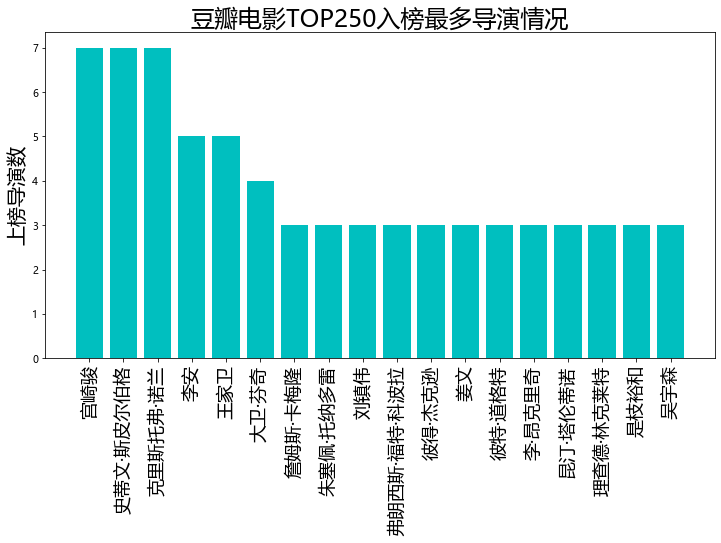

In [15]:
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 入榜导演排行
top_director_name = [i[0] for i in top_directors]
top_director_cnt = [i[1] for i in top_directors]

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(top_director_name, top_director_cnt, color='c')
ax.set_xticklabels(labels=top_director_name, 
                   fontdict={
                       'fontsize': 18, 
                       'rotation': 'vertical'
                   })
plt.ylabel('上榜导演数', fontsize=20)
plt.title('豆瓣电影TOP250入榜最多导演情况', fontsize=24)


In [8]:

top_dire_score = defaultdict(list)
top_dire_ind = defaultdict(list)
for name, cnt in top_directors:
    for index, row in df.iterrows():
        if name in row['director']:
            top_dire_score[name].append(row['score'])
            top_dire_ind[name].append(row['top_no'])
print(top_dire_score)  # 评分
print(top_dire_ind)  # 榜单位置


defaultdict(<class 'list'>, {'宫崎骏': [9.3, 9.2, 9.1, 9.0, 8.9, 8.8, 8.6], '史蒂文·斯皮尔伯格': [9.5, 9.0, 8.9, 8.8, 8.7, 8.6, 8.6], '克里斯托弗·诺兰': [9.3, 9.3, 9.2, 8.8, 8.7, 8.6, 8.9], '李安': [9.0, 9.1, 8.8, 8.9, 8.4], '王家卫': [8.9, 8.7, 8.6, 8.6, 8.5], '大卫·芬奇': [9.0, 8.9, 8.8, 8.7], '詹姆斯·卡梅隆': [9.4, 8.7, 8.7], '朱塞佩·托纳多雷': [9.2, 9.2, 8.8], '刘镇伟': [9.2, 9.0, 8.7], '弗朗西斯·福特·科波拉': [9.3, 9.2, 8.8], '彼得·杰克逊': [9.2, 9.0, 9.0], '姜文': [9.2, 8.8, 8.8], '彼特·道格特': [9.0, 8.7, 8.7], '李·昂克里奇': [9.0, 8.7, 8.8], '昆汀·塔伦蒂诺': [8.8, 8.7, 8.5], '理查德·林克莱特': [8.8, 8.8, 8.8], '是枝裕和': [9.1, 8.7, 8.8], '吴宇森': [8.7, 8.8, 8.5]})
defaultdict(<class 'list'>, {'宫崎骏': [7, 18, 36, 40, 92, 129, 189], '史蒂文·斯皮尔伯格': [8, 70, 71, 128, 176, 186, 241], '克里斯托弗·诺兰': [9, 16, 26, 74, 124, 154, 226], '李安': [30, 58, 95, 142, 246], '王家卫': [82, 98, 149, 161, 199], '大卫·芬奇': [43, 63, 75, 104], '詹姆斯·卡梅隆': [6, 89, 214], '朱塞佩·托纳多雷': [15, 37, 68], '刘镇伟': [17, 38, 113], '弗朗西斯·福特·科波拉': [21, 53, 152], '彼得·杰克逊': [32, 51, 55], '姜文': [33, 67, 96], '彼特·道格特': [3

In [9]:
director_rank_score = []
director_rank_ind = []

for name, scores in top_dire_score.items():
    director_rank_score.append([name, sum(scores) / len(scores)
                       * sqrt(log2(len(scores)))])

for name, indexes in top_dire_ind.items():
    director_rank_ind.append(
        [name, sum(indexes) / sqrt(log2(len(scores))) / len(indexes)])

director_rank_score = sorted(director_rank_score, key=lambda x: x[1], reverse=True)
director_rank_ind = sorted(director_rank_ind, key=lambda x: x[1])

print(director_rank_score[:10])  # 加权得分榜
print(director_rank_ind[:10])  # 加权位置榜


[['宫崎骏', 15.05571088825001], ['克里斯托弗·诺兰', 15.031774940891902], ['史蒂文·斯皮尔伯格', 14.864223309385146], ['李安', 13.470280774053295], ['王家卫', 13.195999038835016], ['大卫·芬奇', 12.515790027001891], ['弗朗西斯·福特·科波拉', 11.45647173804915], ['朱塞佩·托纳多雷', 11.414506640107579], ['彼得·杰克逊', 11.414506640107579], ['刘镇伟', 11.288611346282863]]
[['朱塞佩·托纳多雷', 31.772434683453707], ['彼得·杰克逊', 36.53829988597176], ['刘镇伟', 44.48140855683519], ['姜文', 51.89497664964105], ['大卫·芬奇', 56.594649279901915], ['宫崎骏', 57.98469329730302], ['弗朗西斯·福特·科波拉', 59.83808532050448], ['克里斯托弗·诺兰', 71.37450505675851], ['詹姆斯·卡梅隆', 81.8140193098933], ['李·昂克里奇', 82.07878959892209]]


可以看到，在**加权得分**算法下，宫崎骏以微弱优势胜出，夺得豆瓣最佳导演奖。  
然而在**加权榜单**位置算法中，朱塞佩·托纳多雷的电影平均能获得更靠前的豆瓣排名，夺得桂冠，而宫崎骏和诺兰的排名则分列6、8位。

Text(0.5, 1.0, '豆瓣电影TOP250导演加权得分榜')

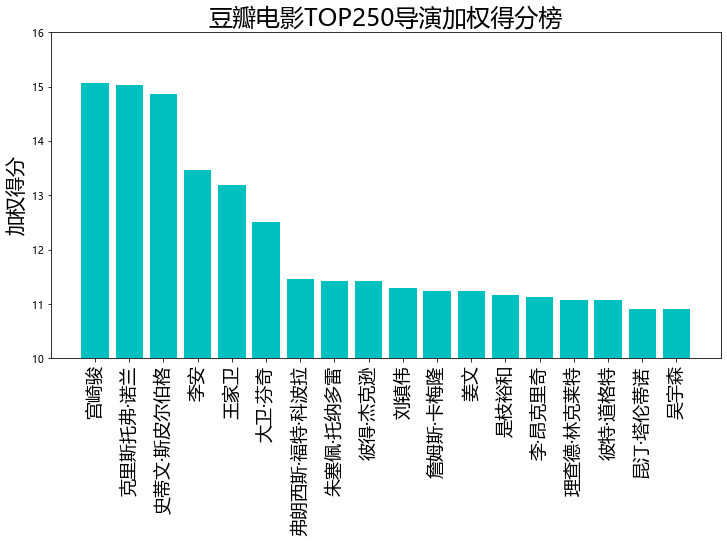

In [16]:
# 加权得分榜
rank_director_name = [i[0] for i in director_rank_score]
rank_director_score = [i[1] for i in director_rank_score]

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(rank_director_name, rank_director_score, color='c')
ax.set_xticklabels(labels=rank_director_name,
                   fontdict={
                       'fontsize': 18, 
                       'rotation': 'vertical'
                   })
plt.ylim([10,16])
plt.ylabel('加权得分', fontsize=20)
plt.title('豆瓣电影TOP250导演加权得分榜', fontsize=24)


### 2. 谁是豆瓣最佳演员？

In [11]:
actor_list = reduce(lambda x, y: x + y, df.actors)
print(len(actor_list))

actor_counter = Counter(actor_list)
actor_counter = sorted(actor_counter.items(), key=lambda x: x[1], reverse=True)
top_actors = list(filter(lambda x: x[1] >= 3, actor_counter))
print(top_actors)



4048
[('张国荣', 8), ('梁朝伟', 8), ('雨果·维文', 7), ('张曼玉', 7), ('汤姆·汉克斯', 6), ('莱昂纳多·迪卡普里奥', 6), ('琼·艾伦', 6), ('马特·达蒙', 6), ('布拉德·皮特', 6), ('伊桑·霍克', 6), ('艾伦·瑞克曼', 6), ('摩根·弗里曼', 5), ('加里·奥德曼', 5), ('迈克尔·凯恩', 5), ('约翰·拉岑贝格', 5), ('周星驰', 5), ('奥兰多·布鲁姆', 5), ('凯拉·奈特莉', 5), ('神木隆之介', 4), ('拉尔夫·费因斯', 4), ('汤姆·哈迪', 4), ('阿尔·帕西诺', 4), ('邦尼·亨特', 4), ('维果·莫腾森', 4), ('凯特·布兰切特', 4), ('安迪·瑟金斯', 4), ('姜文', 4), ('海伦娜·伯翰·卡特', 4), ('杰瑞德·莱托', 4), ('约翰·赫特', 4), ('詹妮弗·康纳利', 4), ('丹尼尔·雷德克里夫', 4), ('艾玛·沃森', 4), ('鲁伯特·格林特', 4), ('玛吉·史密斯', 4), ('汤姆·费尔顿', 4), ('朱丽·沃特斯', 4), ('邦妮·怀特', 4), ('刘嘉玲', 4), ('林青霞', 4), ('树木希林', 4), ('巩俐', 3), ('葛优', 3), ('海利·乔·奥斯蒙', 3), ('娜塔莉·波特曼', 3), ('连姆·尼森', 3), ('基里安·墨菲', 3), ('玛丽昂·歌迪亚', 3), ('拉什·费加', 3), ('杰斯·哈梅尔', 3), ('阿米尔·汗', 3), ('雅克·贝汉', 3), ('安妮·海瑟薇', 3), ('卡西·阿弗莱克', 3), ('乔什·斯图沃特', 3), ('吴孟达', 3), ('蓝洁瑛', 3), ('莫文蔚', 3), ('李健仁', 3), ('坂本千夏', 3), ('岛本须美', 3), ('鳕子', 3), ('黛安·基顿', 3), ('塔莉娅·夏尔', 3), ('艾伦·图代克', 3), ('凯蒂·洛斯', 3), ('克里斯蒂安·贝尔', 3), ('姜武', 3), ('诺玛·威登', 3), ('伊利亚·伍德'

Text(0.5, 1.0, '豆瓣电影TOP250入榜最多演员情况')

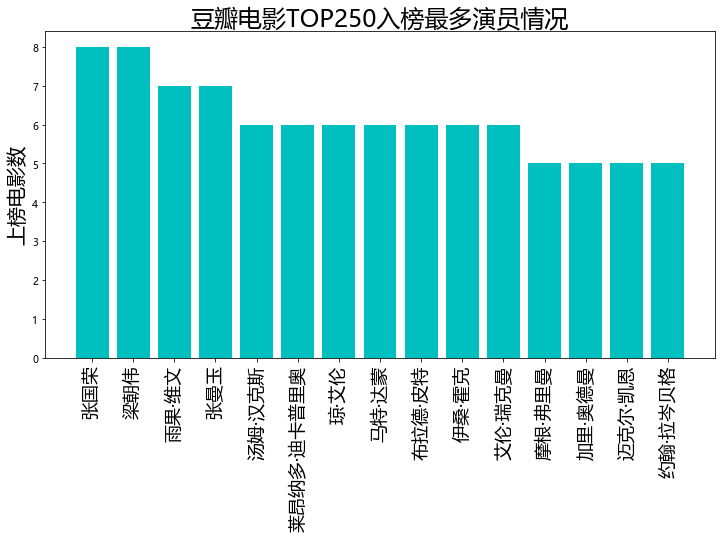

In [17]:
# 入榜电影数排行
actor_name = []
actor_cnt = []
for i in range(0, 15):
    actor_name.append(top_actors[i][0])
    actor_cnt.append(top_actors[i][1])

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(actor_name, actor_cnt, color='c')
ax.set_xticklabels(labels=actor_name, 
                   fontdict={
                       'fontsize': 18, 
                       'rotation': 'vertical'
                   })
plt.ylabel('上榜电影数', fontsize=20)
plt.title('豆瓣电影TOP250入榜最多演员情况', fontsize=24)


In [14]:
top_actor_score = defaultdict(list)
top_actor_ind = defaultdict(list)
for name, cnt in top_actors:
    for index, row in df.iterrows():
        if name in row['actors']:
            top_actor_score[name].append(row['score'])
            top_actor_ind[name].append(row['top_no'])
print(top_actor_score)  # 评分
print(top_actor_ind)  # 榜单位置


defaultdict(<class 'list'>, {'张国荣': [9.6, 8.9, 8.7, 8.7, 8.7, 8.6, 8.8, 8.5], '梁朝伟': [9.2, 8.9, 8.7, 8.7, 8.6, 8.6, 8.5, 8.4], '雨果·维文': [9.2, 9.0, 9.0, 8.9, 8.9, 8.7, 8.7], '张曼玉': [8.7, 8.8, 8.6, 8.6, 8.5, 8.5, 8.6], '汤姆·汉克斯': [9.5, 9.0, 8.9, 8.8, 8.8, 8.8], '莱昂纳多·迪卡普里奥': [9.4, 9.3, 8.9, 8.8, 8.7, 8.6], '琼·艾伦': [9.3, 8.8, 8.5, 8.8, 8.6, 8.5], '马特·达蒙': [9.3, 9.0, 8.9, 8.8, 8.6, 8.6], '布拉德·皮特': [9.0, 8.9, 8.8, 8.8, 8.5, 8.7], '伊桑·霍克': [9.1, 8.8, 8.8, 8.6, 8.8, 8.7], '艾伦·瑞克曼': [8.9, 8.8, 8.6, 8.5, 8.5, 8.5], '摩根·弗里曼': [9.7, 9.2, 8.8, 8.7, 8.6], '加里·奥德曼': [9.4, 9.2, 8.8, 8.7, 8.5], '迈克尔·凯恩': [9.3, 9.3, 9.2, 8.8, 8.7], '约翰·拉岑贝格': [9.3, 9.0, 9.0, 8.7, 8.7], '周星驰': [9.2, 9.0, 8.7, 8.6, 8.4], '奥兰多·布鲁姆': [9.2, 9.0, 9.0, 8.7, 8.6], '凯拉·奈特莉': [8.7, 8.6, 8.6, 8.6, 8.5], '神木隆之介': [9.3, 9.0, 8.8, 8.4], '拉尔夫·费因斯': [9.5, 8.8, 8.8, 8.5], '汤姆·哈迪': [9.3, 8.7, 8.6, 8.6], '阿尔·帕西诺': [9.3, 9.0, 9.2, 8.8], '邦尼·亨特': [9.2, 8.7, 8.7, 8.8], '维果·莫腾森': [9.2, 9.0, 9.0, 8.9], '凯特·布兰切特': [9.2, 9.0, 9.0, 8.9], '安迪·瑟金斯'

In [19]:
actor_rank_score = []
actor_rank_ind = []

for name, scores in top_actor_score.items():
    actor_rank_score.append([name, sum(scores) / len(scores)
                       * sqrt(log2(len(scores)))])

for name, indexes in top_actor_ind.items():
    actor_rank_ind.append(
        [name, sum(indexes) / sqrt(log2(len(scores))) / len(indexes)])

actor_rank_score = sorted(actor_rank_score, key=lambda x: x[1], reverse=True)
actor_rank_ind = sorted(actor_rank_ind, key=lambda x: x[1])

print(actor_rank_score[:10])  # 加权得分榜
print(actor_rank_ind[:10])  # 加权位置榜


[['张国荣', 15.26369774170073], ['梁朝伟', 15.068842025849234], ['雨果·维文', 14.93603115145947], ['张曼玉', 14.433376256939201], ['汤姆·汉克斯', 14.4164439872854], ['莱昂纳多·迪卡普里奥', 14.389647622996765], ['马特·达蒙', 14.255665801553592], ['伊桑·霍克', 14.14848034439905], ['布拉德·皮特', 14.121683980110419], ['琼·艾伦', 14.068091251533152]]
[['葛优', 25.417947746762966], ['姜武', 33.625826706655175], ['伊利亚·伍德', 36.53829988597176], ['西恩·奥斯汀', 36.53829988597176], ['丽芙·泰勒', 36.53829988597176], ['伊恩·麦克莱恩', 36.53829988597176], ['多米尼克·莫纳汉', 36.53829988597176], ['克里斯托弗·李', 36.53829988597176], ['约翰·瑞斯-戴维斯', 36.53829988597176], ['迈克尔·凯恩', 39.556681180899865]]


Text(0.5, 1.0, '豆瓣电影TOP250演员加权得分榜')

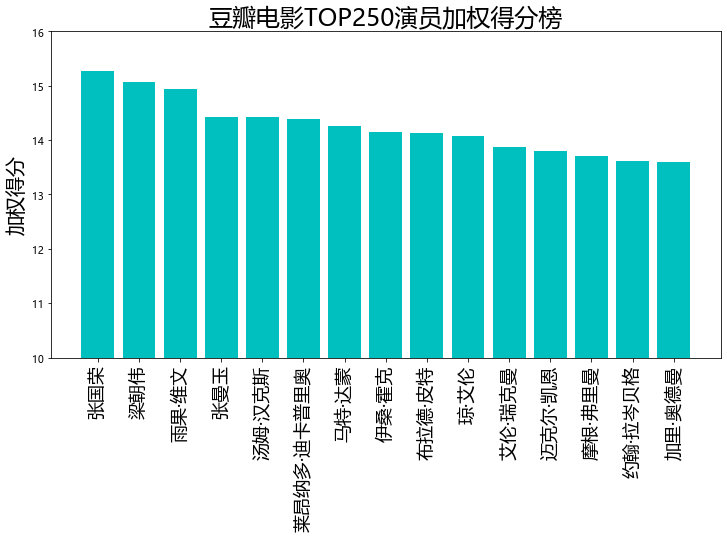

In [20]:
# 加权得分榜
actor_name = []
actor_score = []
for i in range(0,15):
    actor_name.append(actor_rank_score[i][0])
    actor_score.append(actor_rank_score[i][1])

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(actor_name, actor_score, color='c')
ax.set_xticklabels(labels=actor_name, 
                   fontdict={
                       'fontsize': 18, 
                       'rotation': 'vertical'
                   })
plt.ylim([10,16])
plt.ylabel('加权得分', fontsize=20)
plt.title('豆瓣电影TOP250演员加权得分榜', fontsize=24)



“哥哥”张国荣获得豆瓣最佳演员奖。

### 3. TOP250分数及评分人数分布

Text(0.5, 1.0, '豆瓣电影TOP250评分分布')

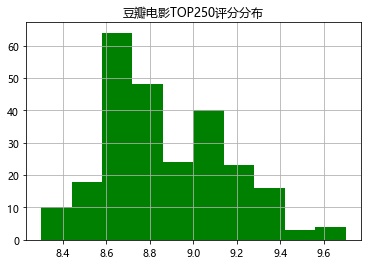

In [14]:
df.score.hist(color='green')
plt.title('豆瓣电影TOP250评分分布')


9分以上的比例不算很高，在8.7、8.8附近有较多电影集中。

Text(0.5, 1.0, '豆瓣电影TOP250评分人数分布')

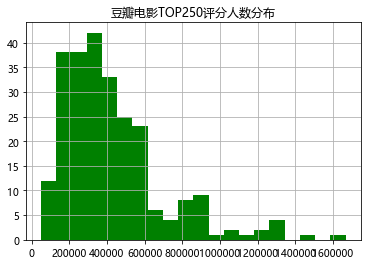

In [15]:
df.score_cnt.hist(bins=20, color='green')
plt.title('豆瓣电影TOP250评分人数分布')


大多数电影的评分人数在60万以下。

 ### 4. 哪些类型的电影更受豆瓣用户欢迎？

Text(0.5, 1.0, '豆瓣电影TOP250分类电影分布')

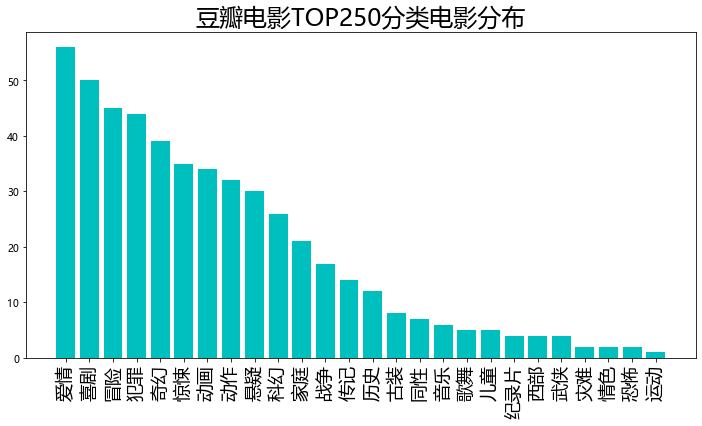

In [21]:
# 调整数据
type_list = reduce(lambda x, y: x + y, df.types)
type_counter = Counter(type_list)
type_counter = sorted(type_counter.items(), key=lambda x: x[1], reverse=True)
types = [i[0] for i in type_counter]
cnts = [i[1] for i in type_counter]

# 作图
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(types[1:], cnts[1:], color='c')
ax.set_xticklabels(
    labels=types[1:],
    fontdict={
        'rotation': 'vertical',
        'fontsize': 18
    })
ax.set_title('豆瓣电影TOP250分类电影分布', fontsize=24)


这里我们去除了最多的“剧情”类电影，因为这个分类实在是太多了，大部分的电影都是有剧情的，所以我们选择剔除掉它。可以看到爱情、喜剧、犯罪、冒险四类是豆瓣用户最喜欢的分类。

### 5. 哪些变量最相关？

In [17]:
df.corr()


,score,score_cnt,top_no,length,had_seen,want_see,short_review,review,ask,discussion,year,five_star_rate,favor_rate,better_than
score,1.000000,0.315311,-0.707974,0.214055,0.279622,0.366693,0.246040,0.185436,0.039566,0.144889,-0.312900,0.982699,0.949960,0.587971
score_cnt,0.315311,1.000000,-0.639462,0.118956,0.962289,0.321597,0.905066,0.720013,0.251359,0.602686,0.212452,0.325069,0.259013,0.227251
top_no,-0.707974,-0.639462,1.000000,-0.194254,-0.587548,-0.374548,-0.518289,-0.365099,-0.120157,-0.287061,0.047517,-0.695480,-0.672270,-0.509184
length,0.214055,0.118956,-0.194254,1.000000,0.094274,0.111099,0.068665,0.105372,0.108926,0.133273,-0.110545,0.219009,0.159849,0.210572
had_seen,0.279622,0.962289,-0.587548,0.094274,1.000000,0.398734,0.884648,0.770163,0.212416,0.690002,0.190343,0.286619,0.224918,0.200856
want_see,0.366693,0.321597,-0.374548,0.111099,0.398734,1.000000,0.495335,0.605874,0.113664,0.558050,0.042439,0.362232,0.382233,0.205527
short_review,0.246040,0.905066,-0.518289,0.068665,0.884648,0.495335,1.000000,0.866370,0.381617,0.699990,0.341383,0.266203,0.201510,0.155699
review,0.185436,0.720013,-0.365099,0.105372,0.770163,0.605874,0.866370,1.000000,0.276596,0.802985,0.291063,0.213791,0.133363,0.042140
ask,0.039566,0.251359,-0.120157,0.108926,0.212416,0.113664,0.381617,0.276596,1.000000,0.164233,0.231980,0.049588,0.026470,0.052137
discussion,0.144889,0.602686,-0.287061,0.133273,0.690002,0.558050,0.699990,0.802985,0.164233,1.000000,0.218400,0.163281,0.103085,0.118175


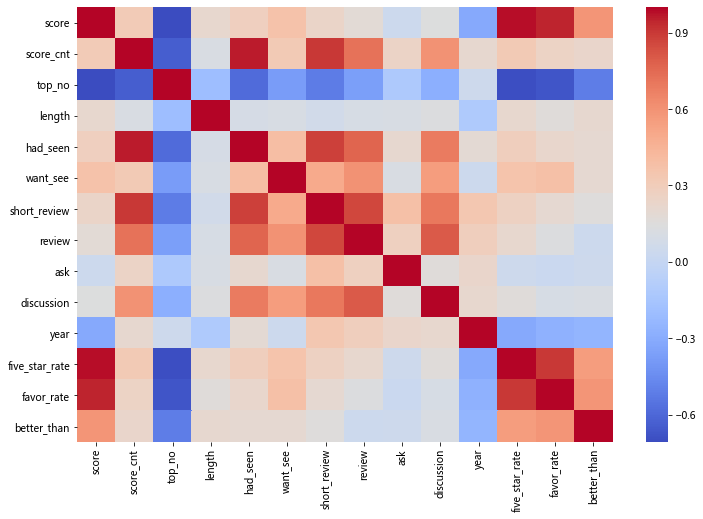

In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()


首先，对角线的相关性都为1，这个可以忽略，因为同样的数据之间的相关性始终为1；  
然后我们注意到，五星比例和好评率与评分之间有非常强的相关性，这个也符合预期，五星比例、好评比例越高，分数自然更高；  
然后就是榜单排名和分数等变量之间的负相关，这个也正常，因为排名数字越低代表排名越靠前，分数高是符合预期的；  
然后就是评分人数和已看人数、短评、影评数量等之间的正相关，这个也是符合我们预期的。  
看起来这里我们发现不了什么，因为这些都是符合我们的经验的。未来如果想要拿这些数据训练模型，这些高度相关的特征可能需要通过主成分分析等方法进行降维，因为他们包含的信息很可能是一致的。

### 6. 评分人数和已看人数之间什么关系？

前边我们已经知道了，它们两个高度正相关，我们现在拿这两个变量做一个简单的线性回归，用评分人数推测已看人数。

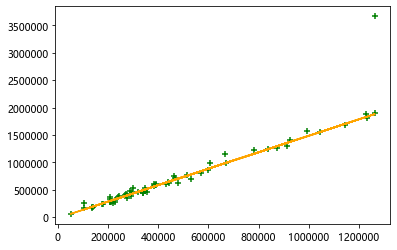

In [19]:

lr = LinearRegression(fit_intercept=True)
X = df['score_cnt'].values
y = df['had_seen'].values
X.shape = (len(X), 1)

# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 训练模型
lr.fit(X_train, y_train)

# 预测
y_pred = lr.predict(X_test)

# 画图
plt.scatter(X_test, y_test, color='green', marker='+')
plt.plot(X_test, y_pred, '-', color='orange')
plt.show()


可以看到，我们的预测和实际情况非常接近，基本上实际表现的那些点都围绕着我们预测的直线上下波动。

In [20]:
print(lr.coef_, lr.intercept_)
# [1.63808659] -62105.59721617866


[1.50160832] -17024.52928980859


### 7. 哪些年头的电影更受豆瓣人喜爱？

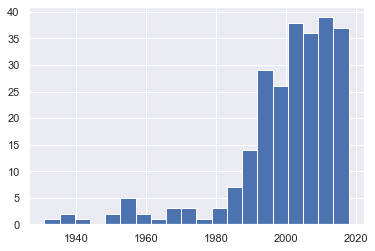

In [21]:
sns.set()
df.year.hist(bins=20)


可以看到，当代的电影还是绝对主力，毕竟老旧的电影在视觉效果上会差很多，只有极少数非常经典、优秀的剧本才可以超越视觉。

### 8. 豆瓣人喜欢的电影有哪些标签？

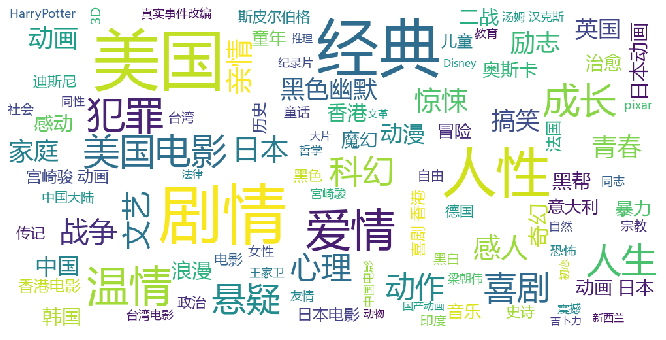

In [23]:

# 生成数据，每个词之间以空格分离
tags = reduce(lambda x, y: x + y, df.tags)
result = ' '.join(tags)

# 设置词云属性，注意要指定中文字体
wc = WordCloud(
    font_path= r'C:\Windows\Fonts\msyh.ttc',  # 字体
    background_color='white',  # 背景颜色
    width=1000,
    height=500,
    max_font_size=100,  # 字体大小
    min_font_size=10,
    max_words=100
)

# 生成云词对象
wc.generate(result)

# 展示词云
plt.figure('豆瓣电影标签', figsize=(12, 6))
plt.imshow(wc)
plt.axis('off')
plt.show()


可以看到，在豆瓣人喜欢的电影中，有那么几类格外突出，比如美国、经典、剧情、爱情、人性、犯罪、温情、悬疑等。